In [120]:
import random
import numpy as np
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


In [121]:
from open_spiel.python import policy
from open_spiel.python.algorithms import expected_game_score
import pyspiel

import open_spiel.python.pytorch.deep_cfr as deep_cfr
from importlib import reload
reload(deep_cfr)
import open_spiel.python.pytorch.deep_cfr as deep_cfr

# import open_spiel.python.algorithms.tf.deep_cfr_tf2 as tf_cfr
# import open_spiel.python.jax.deep_cfr as jx_cfr

from open_spiel.python.algorithms import cfr

In [122]:
# from absl import flags
# FLAGS = flags.FLAGS

# flags.DEFINE_integer("num_iterations", 400, "Number of iterations")
# flags.DEFINE_integer("num_traversals", 40, "Number of traversals/games")
# flags.DEFINE_string("game_name", "kuhn_poker", "Name of the game")

In [123]:
game = pyspiel.load_game("kuhn_poker")

In [124]:
game.information_state_tensor_shape()

[11]

In [81]:
set_seed(1234)
solver = cfr.CFRSolver(game)

In [82]:
num_iters = 200
game_name = "kuhn_poker"

print(f"Running tabular CFR on {game_name} for {num_iters} iterations...")

eval_every=20
iters = []
conv_hist = []
v0_hist = []
v1_hist = []
    
for i in range(num_iters):
    solver.evaluate_and_update_policy()
    if (i + 1) % eval_every == 0:
        print(f"  Iteration {i + 1}/{num_iters}")
        avg_policy = solver.average_policy()
        pyspiel_policy = policy.python_policy_to_pyspiel_policy(avg_policy)
        conv = pyspiel.nash_conv(game, pyspiel_policy)
        
        values = expected_game_score.policy_value(
                game.new_initial_state(),
                [avg_policy, avg_policy]
            )
        
        iters.append(i + 1)
        conv_hist.append(conv)
        v0_hist.append(values[0])
        v1_hist.append(values[1])

        print(
            f"[iter {i+1:5d}] "
            f"NashConv = {conv:.6f}, "
            f"P0 = {values[0]:.4f}, P1 = {values[1]:.4f}"
        )

        

Running tabular CFR on kuhn_poker for 200 iterations...
  Iteration 20/200
[iter    20] NashConv = 0.081340, P0 = -0.0572, P1 = 0.0572
  Iteration 40/200
[iter    40] NashConv = 0.043465, P0 = -0.0565, P1 = 0.0565
  Iteration 60/200
[iter    60] NashConv = 0.028741, P0 = -0.0565, P1 = 0.0565
  Iteration 80/200
[iter    80] NashConv = 0.019803, P0 = -0.0563, P1 = 0.0563
  Iteration 100/200
[iter   100] NashConv = 0.016452, P0 = -0.0561, P1 = 0.0561
  Iteration 120/200
[iter   120] NashConv = 0.016157, P0 = -0.0559, P1 = 0.0559
  Iteration 140/200
[iter   140] NashConv = 0.012059, P0 = -0.0560, P1 = 0.0560
  Iteration 160/200
[iter   160] NashConv = 0.010327, P0 = -0.0560, P1 = 0.0560
  Iteration 180/200
[iter   180] NashConv = 0.010502, P0 = -0.0559, P1 = 0.0559
  Iteration 200/200
[iter   200] NashConv = 0.006659, P0 = -0.0559, P1 = 0.0559


In [83]:
conv_hist

[0.08134039550540403,
 0.043465436256048595,
 0.028741148436245964,
 0.019802861233744945,
 0.01645195463183039,
 0.016157121393947517,
 0.012059456509024312,
 0.0103273040834733,
 0.010502414438449174,
 0.006659206272642902]

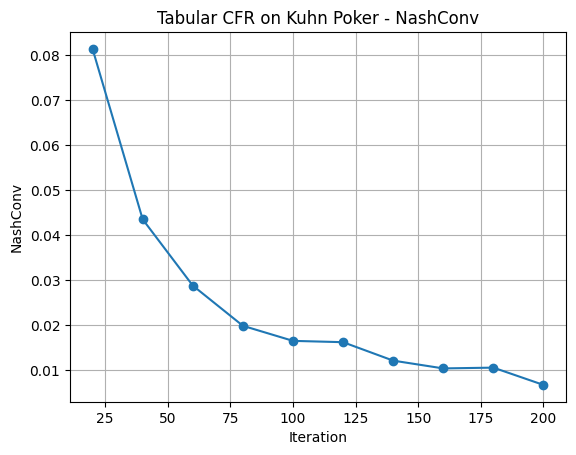

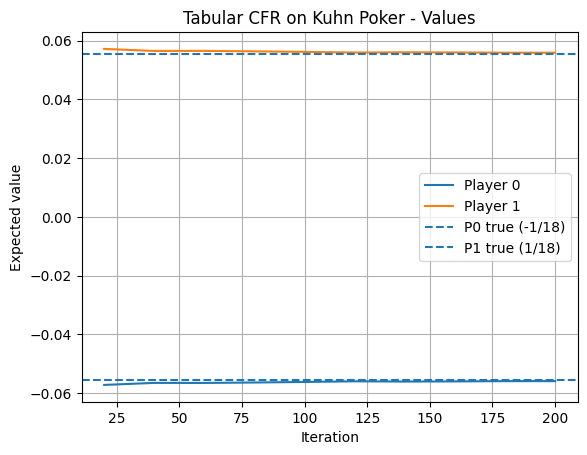

In [69]:
import matplotlib.pyplot as plt

# 画 NashConv 轨迹
plt.figure()
plt.plot(iters, conv_hist, marker="o")
plt.xlabel("Iteration")
plt.ylabel("NashConv")
plt.title("Tabular CFR on Kuhn Poker - NashConv")
plt.grid(True)
plt.show()

# 画 player values 轨迹
plt.figure()
plt.plot(iters, v0_hist, label="Player 0")
plt.plot(iters, v1_hist, label="Player 1")
plt.axhline(-1/18, linestyle="--", label="P0 true (-1/18)")
plt.axhline(1/18, linestyle="--", label="P1 true (1/18)")
plt.xlabel("Iteration")
plt.ylabel("Expected value")
plt.title("Tabular CFR on Kuhn Poker - Values")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
set_seed(1234)
deep_cfr_solver = deep_cfr.DeepCFRSolver(
    game,
    policy_network_layers=(32, 32),
    advantage_network_layers=(16, 16),
    num_iterations=200,
    num_traversals=40,
    learning_rate=1e-3,
    batch_size_advantage=None,
    batch_size_strategy=None,
    memory_capacity=int(1e7),
    log_nash_conv=True,
    log_freq=20,
    )

Finished deep CFR model


In [94]:
_, advantage_losses, policy_loss, iters, conv_hist, v0_hist, v1_hist = deep_cfr_solver.solve()

[DeepCFR][iter 1/200] NashConv = 1.035324
[DeepCFR][iter 20/200] NashConv = 0.775381
[DeepCFR][iter 40/200] NashConv = 0.930509
[DeepCFR][iter 60/200] NashConv = 0.909438
[DeepCFR][iter 80/200] NashConv = 0.915693
[DeepCFR][iter 100/200] NashConv = 0.993118
[DeepCFR][iter 120/200] NashConv = 0.988793
[DeepCFR][iter 140/200] NashConv = 0.982510
[DeepCFR][iter 160/200] NashConv = 1.018213
[DeepCFR][iter 180/200] NashConv = 0.956836
[DeepCFR][iter 200/200] NashConv = 0.959008


In [95]:
conv_hist

[1.0353242032015273,
 0.7753813123539376,
 0.9305086784260054,
 0.9094378398360826,
 0.9156930931527498,
 0.9931182516201076,
 0.9887929650436043,
 0.9825100292506697,
 1.0182134297854664,
 0.9568360590854516,
 0.9590084050602349]

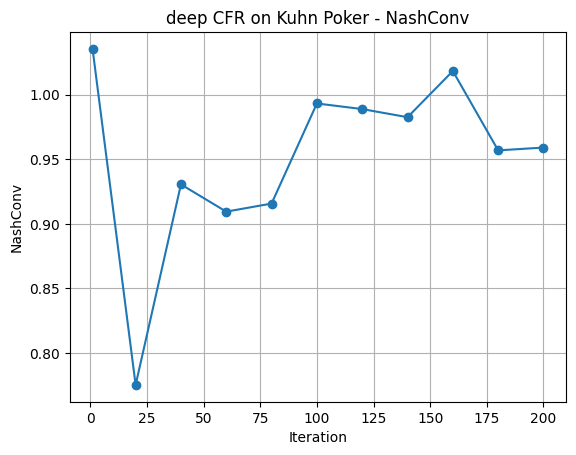

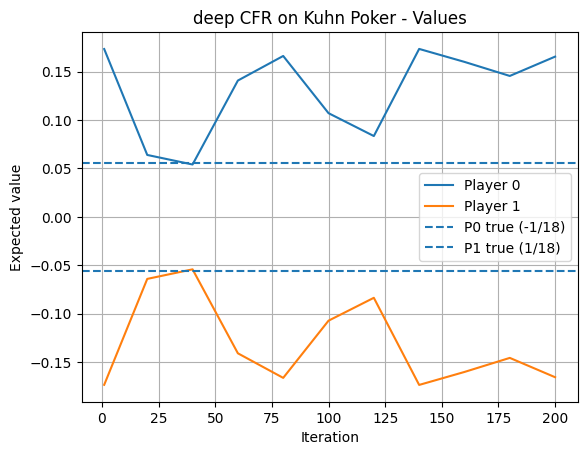

In [96]:
import matplotlib.pyplot as plt

# 画 NashConv 轨迹
plt.figure()
plt.plot(iters, conv_hist, marker="o")
plt.xlabel("Iteration")
plt.ylabel("NashConv")
plt.title("deep CFR on Kuhn Poker - NashConv")
plt.grid(True)
plt.show()

# 画 player values 轨迹
plt.figure()
plt.plot(iters, v0_hist, label="Player 0")
plt.plot(iters, v1_hist, label="Player 1")
plt.axhline(-1/18, linestyle="--", label="P0 true (-1/18)")
plt.axhline(1/18, linestyle="--", label="P1 true (1/18)")
plt.xlabel("Iteration")
plt.ylabel("Expected value")
plt.title("deep CFR on Kuhn Poker - Values")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
avg_policy = policy.tabular_policy_from_callable(
    game, deep_cfr_solver.action_probabilities
)

In [59]:
pyspiel_policy = policy.python_policy_to_pyspiel_policy(avg_policy)
conv = pyspiel.nash_conv(game, pyspiel_policy)
conv

1.018900869009952

In [60]:
average_policy_values = expected_game_score.policy_value(
    game.new_initial_state(),
    [avg_policy, avg_policy]  # 两个玩家都用同一个平均策略
)
average_policy_values

array([ 0.16885978, -0.16885978])

In [61]:
deep_cfr_solver._nash_conv_history

[1.0353242032015273,
 1.0353242032015273,
 1.0353242032015273,
 1.0353242032015273,
 1.0353242032015273]

# Teacher-student model

In [97]:
set_seed(1234)
solver = cfr.CFRSolver(game)

In [98]:
num_iters = 200
game_name = "kuhn_poker"

print(f"Running tabular CFR on {game_name} for {num_iters} iterations...")

eval_every=20
iters = []
conv_hist = []
v0_hist = []
v1_hist = []
    
for i in range(num_iters):
    solver.evaluate_and_update_policy()
    if (i + 1) % eval_every == 0:
        print(f"  Iteration {i + 1}/{num_iters}")
        avg_policy = solver.average_policy()
        pyspiel_policy = policy.python_policy_to_pyspiel_policy(avg_policy)
        conv = pyspiel.nash_conv(game, pyspiel_policy)
        
        values = expected_game_score.policy_value(
                game.new_initial_state(),
                [avg_policy, avg_policy]
            )
        
        iters.append(i + 1)
        conv_hist.append(conv)
        v0_hist.append(values[0])
        v1_hist.append(values[1])

        print(
            f"[iter {i+1:5d}] "
            f"NashConv = {conv:.6f}, "
            f"P0 = {values[0]:.4f}, P1 = {values[1]:.4f}"
        )

        

Running tabular CFR on kuhn_poker for 200 iterations...
  Iteration 20/200
[iter    20] NashConv = 0.081340, P0 = -0.0572, P1 = 0.0572
  Iteration 40/200
[iter    40] NashConv = 0.043465, P0 = -0.0565, P1 = 0.0565
  Iteration 60/200
[iter    60] NashConv = 0.028741, P0 = -0.0565, P1 = 0.0565
  Iteration 80/200
[iter    80] NashConv = 0.019803, P0 = -0.0563, P1 = 0.0563
  Iteration 100/200
[iter   100] NashConv = 0.016452, P0 = -0.0561, P1 = 0.0561
  Iteration 120/200
[iter   120] NashConv = 0.016157, P0 = -0.0559, P1 = 0.0559
  Iteration 140/200
[iter   140] NashConv = 0.012059, P0 = -0.0560, P1 = 0.0560
  Iteration 160/200
[iter   160] NashConv = 0.010327, P0 = -0.0560, P1 = 0.0560
  Iteration 180/200
[iter   180] NashConv = 0.010502, P0 = -0.0559, P1 = 0.0559
  Iteration 200/200
[iter   200] NashConv = 0.006659, P0 = -0.0559, P1 = 0.0559


In [100]:
avg_tab_policy = solver.average_policy()
avg_tab_policy = policy.python_policy_to_pyspiel_policy(avg_tab_policy)

In [108]:
import numpy as np

X = []  # info_state_tensor
Y = []  # 对应的 action prob 向量（长度 num_actions）

num_actions = game.num_distinct_actions()

def traverse_collect(state):
    if state.is_terminal():
        return
    if state.is_chance_node():
        for a, _ in state.chance_outcomes():
            traverse_collect(state.child(a))
        return

    cur_player = state.current_player()
    info = np.array(state.information_state_tensor(cur_player))
    # avg_tab_policy 是一个 pyspiel.Policy，可以直接给一个 state 拿 prob
    probs_dict = avg_tab_policy.action_probabilities(state)
    probs_vec = np.zeros(num_actions, dtype=np.float32)
    for a, p in probs_dict.items():
        probs_vec[a] = p

    X.append(info)
    Y.append(probs_vec)

    for a in state.legal_actions():
        traverse_collect(state.child(a))

traverse_collect(game.new_initial_state())
X = np.stack(X)
Y = np.stack(Y)
print("Dataset size:", X.shape, Y.shape)

Dataset size: (24, 11) (24, 2)


In [110]:
import torch
# from open_spiel.python.algorithms import deep_cfr

# 建一个 dummy DeepCFRSolver，只用它的 policy net，不跑 solve()
dummy_deep_cfr_solver = deep_cfr.DeepCFRSolver(
    game,
    policy_network_layers=(256, 256),
    advantage_network_layers=(128, 128),
    num_iterations=1,       # 用不到
    num_traversals=1,       # 用不到
)

net = dummy_deep_cfr_solver._policy_network
softmax = dummy_deep_cfr_solver._policy_sm
criterion = dummy_deep_cfr_solver._loss_policy
optimizer = dummy_deep_cfr_solver._optimizer_policy

X_t = torch.FloatTensor(X)
Y_t = torch.FloatTensor(Y)

for epoch in range(2000):
    optimizer.zero_grad()
    logits = net(X_t)
    preds = softmax(logits)
    loss = criterion(preds, Y_t)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 200 == 0:
        print(f"[Supervised] epoch {epoch+1}, loss = {loss.item():.6f}")

Finished deep CFR model
[Supervised] epoch 200, loss = 0.005345
[Supervised] epoch 400, loss = 0.001043
[Supervised] epoch 600, loss = 0.000305
[Supervised] epoch 800, loss = 0.000117
[Supervised] epoch 1000, loss = 0.000057
[Supervised] epoch 1200, loss = 0.000032
[Supervised] epoch 1400, loss = 0.000020
[Supervised] epoch 1600, loss = 0.000013
[Supervised] epoch 1800, loss = 0.000009
[Supervised] epoch 2000, loss = 0.000006


In [113]:
from open_spiel.python.policy import TabularPolicy

def nn_policy_action_probs(state):
    cur_player = state.current_player()
    info = np.array(state.information_state_tensor(cur_player), dtype=np.float32)
    with torch.no_grad():
        logits = net(torch.FloatTensor(info).unsqueeze(0))
        probs = softmax(logits).numpy()[0]
    # 只返回合法动作的概率，需要重新 normalize 一下
    legal_actions = state.legal_actions(cur_player)
    probs_masked = {a: probs[a] for a in legal_actions}
    s = sum(probs_masked.values())
    if s > 0:
        for a in probs_masked:
            probs_masked[a] /= s
    else:
        # 理论上不会发生，但保险起见
        for a in legal_actions:
            probs_masked[a] = 1.0 / len(legal_actions)
    return probs_masked

avg_nn_policy = policy.tabular_policy_from_callable(
    game, nn_policy_action_probs
)
avg_nn_policy = policy.python_policy_to_pyspiel_policy(avg_nn_policy)
conv_nn = pyspiel.nash_conv(game, avg_nn_policy)
print("NN-supervised NashConv:", conv_nn)

values_nn = expected_game_score.policy_value(
    game.new_initial_state(), [avg_nn_policy, avg_nn_policy]
)
print("NN-supervised values:", values_nn)

NN-supervised NashConv: 0.008741062562428133
NN-supervised values: [-0.05582312  0.05582312]


In [118]:
def collect_supervised_dataset_from_tabular(game, avg_tabular_policy):
    """遍历整棵树，收集 (info_state_tensor, target_action_probs) 数据集."""

    root = game.new_initial_state()
    num_actions = game.num_distinct_actions()
    num_players = game.num_players()

    X = []
    Y = []

    def traverse(state):
        if state.is_terminal():
            return
        if state.is_chance_node():
            for a, _ in state.chance_outcomes():
                traverse(state.child(a))
            return

        current_player = state.current_player()
        # 对当前 player 的 infoset 产生一条 (x, y)
        info_state_vec = np.array(state.information_state_tensor(current_player))
        legal_actions = state.legal_actions(current_player)

        # 从 tabular avg policy 中拿 teacher 的 action prob
        action_prob_dict = avg_tabular_policy.action_probabilities(
            state, player_id=current_player
        )

        target = np.zeros(num_actions, dtype=np.float32)
        for a in legal_actions:
            target[a] = action_prob_dict.get(a, 0.0)

        X.append(info_state_vec)
        Y.append(target)

        # 再继续往下遍历
        for a in legal_actions:
            traverse(state.child(a))

    traverse(root)
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)
    return X, Y

# Train a larger model

In [156]:
set_seed(1234)

In [157]:
deep_cfr_solver = deep_cfr.DeepCFRSolver(
    game,
    policy_network_layers=(32, 32),
    advantage_network_layers=(32, 32),
    num_iterations=800,
    num_traversals=40,
    learning_rate=1e-3,
    batch_size_advantage=512,
    batch_size_strategy=512,
    policy_network_train_steps=100,        # 先保留
    advantage_network_train_steps=1,
    reinitialize_advantage_networks=False, # 你已经改成 False 了
    log_nash_conv=True,
    log_freq=100,
)

Finished deep CFR model


In [158]:
_, advantage_losses, policy_loss, _iters, _conv_hist, _v0_hist, _v1_hist = deep_cfr_solver.solve()

[DeepCFR][iter 1/800] NashConv = 1.035324
[DeepCFR][iter 100/800] NashConv = 1.035324
[DeepCFR][iter 200/800] NashConv = 1.035324
[DeepCFR][iter 300/800] NashConv = 1.035324
[DeepCFR][iter 400/800] NashConv = 1.035324
[DeepCFR][iter 500/800] NashConv = 1.035324
[DeepCFR][iter 600/800] NashConv = 1.035324
[DeepCFR][iter 700/800] NashConv = 1.035324
[DeepCFR][iter 800/800] NashConv = 1.035324


In [163]:
average_policy = policy.tabular_policy_from_callable(
      game, deep_cfr_solver.action_probabilities)

In [164]:
pyspiel_policy = policy.python_policy_to_pyspiel_policy(average_policy)
conv = pyspiel.nash_conv(game, pyspiel_policy)

In [165]:
average_policy_values = expected_game_score.policy_value(
      game.new_initial_state(), [average_policy] * 2)

In [166]:
average_policy_values

array([-0.06133491,  0.06133491])